In [ ]:
from google.colab import drive
drive.flush_and_unmount()   # unmount previous mount safely
!rm -rf /content/drive      # remove old mount folder
drive.mount('/content/drive')

Drive not mounted, so nothing to flush and unmount.
Mounted at /content/drive


In [ ]:
import os
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import (
    ResNet50, VGG16, InceptionV3, EfficientNetB0, MobileNetV2
)
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
# Paths
BASE_DIR = "/content/drive/MyDrive/solarPanelDefectDetection_Binary/binaryClassification"
SAVE_DIR = "/content/drive/MyDrive/solarPanelDefectDetection_Binary/binaryClassification/model_results"
LOG_FILE = os.path.join(SAVE_DIR, "training_log.csv")
# Make sure save directory exists
os.makedirs(SAVE_DIR, exist_ok=True)
# Image Parameters
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
# Data Generators
train_gen = ImageDataGenerator(rescale=1./255).flow_from_directory(
    os.path.join(BASE_DIR, "train"),
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="binary"
)
val_gen = ImageDataGenerator(rescale=1./255).flow_from_directory(
    os.path.join(BASE_DIR, "val"),
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="binary"
)
test_gen = ImageDataGenerator(rescale=1./255).flow_from_directory(
    os.path.join(BASE_DIR, "test"),
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="binary",
    shuffle=False
)

Found 607 images belonging to 2 classes.
Found 173 images belonging to 2 classes.
Found 89 images belonging to 2 classes.


In [ ]:
def build_model(base_model_class, input_shape=(224, 224, 3)):
    base_model = base_model_class(weights="imagenet", include_top=False, input_shape=input_shape)
    base_model.trainable = False

    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(128, activation="relu"),
        layers.Dropout(0.3),
        layers.Dense(1, activation="sigmoid")
    ])
    model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
    return model

In [ ]:
model_classes = {
    "ResNet50": ResNet50,
    "VGG16": VGG16,
    "InceptionV3": InceptionV3,
    "EfficientNetB0": EfficientNetB0,
    "MobileNetV2": MobileNetV2
}
# Prepare log DataFrame
log_records = []
#Training Loop
for model_name, model_class in model_classes.items():
    print(f"\nTraining {model_name}...\n")

    model = build_model(model_class)

    # Callbacks
    checkpoint_path = os.path.join(SAVE_DIR, f"best_{model_name}.h5")
    callbacks = [
        EarlyStopping(patience=5, restore_best_weights=True, monitor="val_loss"),
        ModelCheckpoint(checkpoint_path, save_best_only=True, monitor="val_loss")
    ]
    # Train model
    history = model.fit(
        train_gen,
        validation_data=val_gen,
        epochs=15,
        callbacks=callbacks,
        verbose=1
    )
    # Save final model
    final_model_path = os.path.join(SAVE_DIR, f"final_{model_name}.h5")
    model.save(final_model_path)
    # Log metrics
    from datetime import datetime
    for epoch in range(len(history.history["accuracy"])):
        log_records.append({
            "timestamp": datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
            "model": model_name,
            "epoch": epoch + 1,
            "accuracy": history.history["accuracy"][epoch],
            "val_accuracy": history.history["val_accuracy"][epoch],
            "loss": history.history["loss"][epoch],
            "val_loss": history.history["val_loss"][epoch],
        })

    print(f"Finished {model_name}. Model saved at {final_model_path}")
#Save Log to CSV
df_log = pd.DataFrame(log_records)
df_log.to_csv(LOG_FILE, index=False)

print(f"\nTraining complete! Logs saved to {LOG_FILE}")


Training ResNet50...

Epoch 1/15
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 757ms/step - accuracy: 0.7784 - loss: 0.5425

19/19 ━━━━━━━━━━━━━━━━━━━━ 36s 1s/step - accuracy: 0.7788 - loss: 0.5411 - val_accuracy: 0.8035 - val_loss: 0.4161
Epoch 2/15
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 604ms/step - accuracy: 0.8221 - loss: 0.4262

19/19 ━━━━━━━━━━━━━━━━━━━━ 17s 897ms/step - accuracy: 0.8221 - loss: 0.4261 - val_accuracy: 0.8382 - val_loss: 0.3868
Epoch 3/15
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 649ms/step - accuracy: 0.8468 - loss: 0.3944

19/19 ━━━━━━━━━━━━━━━━━━━━ 18s 915ms/step - accuracy: 0.8461 - loss: 0.3949 - val_accuracy: 0.8324 - val_loss: 0.3840
Epoch 4/15
19/19 ━━━━━━━━━━━━━━━━━━━━ 16s 847ms/step - accuracy: 0.8419 - loss: 0.3870 - val_accuracy: 0.8092 - val_loss: 0.4273
Epoch 5/15
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 586ms/step - accuracy: 0.8257 - loss: 0.4343

19/19 ━━━━━━━━━━━━━━━━━━━━ 17s 908ms/step - accuracy: 0.8262 - loss: 0.4327 - val_accuracy: 0.8382 - val_loss: 0.3785
Epoch 6/15
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 674ms/step - accuracy: 0.8348 - loss: 0.4013

19/19 ━━━━━━━━━━━━━━━━━━━━ 17s 936ms/step - accuracy: 0.8347 - loss: 0.4002 - val_accuracy: 0.8613 - val_loss: 0.3627
Epoch 7/15
19/19 ━━━━━━━━━━━━━━━━━━━━ 19s 830ms/step - accuracy: 0.8349 - loss: 0.3639 - val_accuracy: 0.8613 - val_loss: 0.3666
Epoch 8/15
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 604ms/step - accuracy: 0.8427 - loss: 0.3674

19/19 ━━━━━━━━━━━━━━━━━━━━ 19s 992ms/step - accuracy: 0.8427 - loss: 0.3677 - val_accuracy: 0.8671 - val_loss: 0.3565
Epoch 9/15
19/19 ━━━━━━━━━━━━━━━━━━━━ 16s 811ms/step - accuracy: 0.8205 - loss: 0.3955 - val_accuracy: 0.8671 - val_loss: 0.3610
Epoch 10/15
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 614ms/step - accuracy: 0.8699 - loss: 0.3250

19/19 ━━━━━━━━━━━━━━━━━━━━ 17s 882ms/step - accuracy: 0.8692 - loss: 0.3270 - val_accuracy: 0.8728 - val_loss: 0.3548
Epoch 11/15
19/19 ━━━━━━━━━━━━━━━━━━━━ 16s 796ms/step - accuracy: 0.8662 - loss: 0.3533 - val_accuracy: 0.8671 - val_loss: 0.3646
Epoch 12/15
19/19 ━━━━━━━━━━━━━━━━━━━━ 15s 772ms/step - accuracy: 0.8380 - loss: 0.3638 - val_accuracy: 0.8671 - val_loss: 0.3594
Epoch 13/15
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 615ms/step - accuracy: 0.8546 - loss: 0.3505

19/19 ━━━━━━━━━━━━━━━━━━━━ 22s 901ms/step - accuracy: 0.8549 - loss: 0.3502 - val_accuracy: 0.8786 - val_loss: 0.3513
Epoch 14/15
19/19 ━━━━━━━━━━━━━━━━━━━━ 16s 864ms/step - accuracy: 0.8327 - loss: 0.3602 - val_accuracy: 0.8671 - val_loss: 0.3708
Epoch 15/15
19/19 ━━━━━━━━━━━━━━━━━━━━ 15s 775ms/step - accuracy: 0.8518 - loss: 0.3740 - val_accuracy: 0.8786 - val_loss: 0.3522


Finished ResNet50. Model saved at /content/drive/MyDrive/solarPanelDefectDetection_Binary/binaryClassification/model_results/final_ResNet50.h5

Training VGG16...

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/15
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7205 - loss: 0.5677

19/19 ━━━━━━━━━━━━━━━━━━━━ 51s 2s/step - accuracy: 0.7230 - loss: 0.5667 - val_accuracy: 0.8035 - val_loss: 0.4196
Epoch 2/15
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 627ms/step - accuracy: 0.8025 - loss: 0.4518

19/19 ━━━━━━━━━━━━━━━━━━━━ 16s 865ms/step - accuracy: 0.8029 - loss: 0.4509 - val_accuracy: 0.8092 - val_loss: 0.3668
Epoch 3/15
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 661ms/step - accuracy: 0.8026 - loss: 0.4158

19/19 ━━━━━━━━━━━━━━━━━━━━ 17s 897ms/step - accuracy: 0.8041 - loss: 0.4138 - val_accuracy: 0.8555 - val_loss: 0.3202
Epoch 4/15
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 632ms/step - accuracy: 0.8848 - loss: 0.3313

19/19 ━━━━━━━━━━━━━━━━━━━━ 16s 803ms/step - accuracy: 0.8840 - loss: 0.3318 - val_accuracy: 0.8555 - val_loss: 0.2876
Epoch 5/15
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 656ms/step - accuracy: 0.8824 - loss: 0.3189

19/19 ━━━━━━━━━━━━━━━━━━━━ 17s 915ms/step - accuracy: 0.8819 - loss: 0.3187 - val_accuracy: 0.8671 - val_loss: 0.2770
Epoch 6/15
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 705ms/step - accuracy: 0.8781 - loss: 0.3105

19/19 ━━━━━━━━━━━━━━━━━━━━ 18s 942ms/step - accuracy: 0.8787 - loss: 0.3099 - val_accuracy: 0.8613 - val_loss: 0.2614
Epoch 7/15
19/19 ━━━━━━━━━━━━━━━━━━━━ 15s 820ms/step - accuracy: 0.8754 - loss: 0.2862 - val_accuracy: 0.8671 - val_loss: 0.2747
Epoch 8/15
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 620ms/step - accuracy: 0.8823 - loss: 0.2630

19/19 ━━━━━━━━━━━━━━━━━━━━ 16s 855ms/step - accuracy: 0.8823 - loss: 0.2635 - val_accuracy: 0.9017 - val_loss: 0.2458
Epoch 9/15
19/19 ━━━━━━━━━━━━━━━━━━━━ 20s 798ms/step - accuracy: 0.8954 - loss: 0.2528 - val_accuracy: 0.8902 - val_loss: 0.2511
Epoch 10/15
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 590ms/step - accuracy: 0.8887 - loss: 0.2579

19/19 ━━━━━━━━━━━━━━━━━━━━ 22s 839ms/step - accuracy: 0.8893 - loss: 0.2575 - val_accuracy: 0.8960 - val_loss: 0.2338
Epoch 11/15
19/19 ━━━━━━━━━━━━━━━━━━━━ 16s 814ms/step - accuracy: 0.9214 - loss: 0.2248 - val_accuracy: 0.8960 - val_loss: 0.2363
Epoch 12/15
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 595ms/step - accuracy: 0.9046 - loss: 0.2123

19/19 ━━━━━━━━━━━━━━━━━━━━ 16s 827ms/step - accuracy: 0.9048 - loss: 0.2128 - val_accuracy: 0.9133 - val_loss: 0.2226
Epoch 13/15
19/19 ━━━━━━━━━━━━━━━━━━━━ 15s 802ms/step - accuracy: 0.9371 - loss: 0.1950 - val_accuracy: 0.9017 - val_loss: 0.2296
Epoch 14/15
19/19 ━━━━━━━━━━━━━━━━━━━━ 15s 782ms/step - accuracy: 0.8994 - loss: 0.2329 - val_accuracy: 0.8786 - val_loss: 0.2399
Epoch 15/15
19/19 ━━━━━━━━━━━━━━━━━━━━ 15s 787ms/step - accuracy: 0.9297 - loss: 0.2232 - val_accuracy: 0.9075 - val_loss: 0.2235


Finished VGG16. Model saved at /content/drive/MyDrive/solarPanelDefectDetection_Binary/binaryClassification/model_results/final_VGG16.h5

Training InceptionV3...

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/15
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7362 - loss: 0.8363

19/19 ━━━━━━━━━━━━━━━━━━━━ 54s 2s/step - accuracy: 0.7373 - loss: 0.8278 - val_accuracy: 0.8035 - val_loss: 0.3915
Epoch 2/15
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 619ms/step - accuracy: 0.8371 - loss: 0.3553

19/19 ━━━━━━━━━━━━━━━━━━━━ 17s 896ms/step - accuracy: 0.8369 - loss: 0.3555 - val_accuracy: 0.8844 - val_loss: 0.2993
Epoch 3/15
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 643ms/step - accuracy: 0.8597 - loss: 0.3228

19/19 ━━━━━━━━━━━━━━━━━━━━ 16s 844ms/step - accuracy: 0.8606 - loss: 0.3212 - val_accuracy: 0.9191 - val_loss: 0.2687
Epoch 4/15
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 643ms/step - accuracy: 0.8976 - loss: 0.2690

19/19 ━━━━━━━━━━━━━━━━━━━━ 18s 956ms/step - accuracy: 0.8977 - loss: 0.2684 - val_accuracy: 0.9017 - val_loss: 0.2542
Epoch 5/15
19/19 ━━━━━━━━━━━━━━━━━━━━ 15s 793ms/step - accuracy: 0.9364 - loss: 0.1854 - val_accuracy: 0.8786 - val_loss: 0.3085
Epoch 6/15
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 616ms/step - accuracy: 0.9254 - loss: 0.2108

19/19 ━━━━━━━━━━━━━━━━━━━━ 17s 898ms/step - accuracy: 0.9253 - loss: 0.2105 - val_accuracy: 0.9249 - val_loss: 0.2228
Epoch 7/15
19/19 ━━━━━━━━━━━━━━━━━━━━ 16s 806ms/step - accuracy: 0.9481 - loss: 0.1783 - val_accuracy: 0.9133 - val_loss: 0.2308
Epoch 8/15
19/19 ━━━━━━━━━━━━━━━━━━━━ 17s 896ms/step - accuracy: 0.9398 - loss: 0.1851 - val_accuracy: 0.9249 - val_loss: 0.2385
Epoch 9/15
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 614ms/step - accuracy: 0.9512 - loss: 0.1485

19/19 ━━━━━━━━━━━━━━━━━━━━ 17s 904ms/step - accuracy: 0.9511 - loss: 0.1482 - val_accuracy: 0.9191 - val_loss: 0.1868
Epoch 10/15
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 642ms/step - accuracy: 0.9694 - loss: 0.1090

19/19 ━━━━━━━━━━━━━━━━━━━━ 21s 930ms/step - accuracy: 0.9692 - loss: 0.1093 - val_accuracy: 0.9306 - val_loss: 0.1772
Epoch 11/15
19/19 ━━━━━━━━━━━━━━━━━━━━ 16s 791ms/step - accuracy: 0.9631 - loss: 0.1154 - val_accuracy: 0.9306 - val_loss: 0.1937
Epoch 12/15
19/19 ━━━━━━━━━━━━━━━━━━━━ 14s 758ms/step - accuracy: 0.9732 - loss: 0.0843 - val_accuracy: 0.9306 - val_loss: 0.1888
Epoch 13/15
19/19 ━━━━━━━━━━━━━━━━━━━━ 14s 770ms/step - accuracy: 0.9732 - loss: 0.0793 - val_accuracy: 0.9249 - val_loss: 0.2084
Epoch 14/15
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 585ms/step - accuracy: 0.9689 - loss: 0.0836

19/19 ━━━━━━━━━━━━━━━━━━━━ 17s 861ms/step - accuracy: 0.9690 - loss: 0.0837 - val_accuracy: 0.9364 - val_loss: 0.1753
Epoch 15/15
19/19 ━━━━━━━━━━━━━━━━━━━━ 16s 812ms/step - accuracy: 0.9858 - loss: 0.0611 - val_accuracy: 0.9306 - val_loss: 0.1992


Finished InceptionV3. Model saved at /content/drive/MyDrive/solarPanelDefectDetection_Binary/binaryClassification/model_results/final_InceptionV3.h5

Training EfficientNetB0...

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/15
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6698 - loss: 0.6009

19/19 ━━━━━━━━━━━━━━━━━━━━ 76s 3s/step - accuracy: 0.6746 - loss: 0.5977 - val_accuracy: 0.8035 - val_loss: 0.5011
Epoch 2/15
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 603ms/step - accuracy: 0.7851 - loss: 0.5245

19/19 ━━━━━━━━━━━━━━━━━━━━ 15s 822ms/step - accuracy: 0.7860 - loss: 0.5232 - val_accuracy: 0.8035 - val_loss: 0.4990
Epoch 3/15
19/19 ━━━━━━━━━━━━━━━━━━━━ 15s 782ms/step - accuracy: 0.7855 - loss: 0.5355 - val_accuracy: 0.8035 - val_loss: 0.5031
Epoch 4/15
19/19 ━━━━━━━━━━━━━━━━━━━━ 14s 755ms/step - accuracy: 0.7679 - loss: 0.5761 - val_accuracy: 0.8035 - val_loss: 0.5400
Epoch 5/15
19/19 ━━━━━━━━━━━━━━━━━━━━ 14s 746ms/step - accuracy: 0.8205 - loss: 0.5065 - val_accuracy: 0.8035 - val_loss: 0.5060
Epoch 6/15
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 605ms/step - accuracy: 0.8081 - loss: 0.5043

19/19 ━━━━━━━━━━━━━━━━━━━━ 15s 812ms/step - accuracy: 0.8078 - loss: 0.5049 - val_accuracy: 0.8035 - val_loss: 0.4957
Epoch 7/15
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 619ms/step - accuracy: 0.8105 - loss: 0.4902

19/19 ━━━━━━━━━━━━━━━━━━━━ 15s 816ms/step - accuracy: 0.8101 - loss: 0.4909 - val_accuracy: 0.8035 - val_loss: 0.4954
Epoch 8/15
19/19 ━━━━━━━━━━━━━━━━━━━━ 14s 758ms/step - accuracy: 0.7918 - loss: 0.5132 - val_accuracy: 0.8035 - val_loss: 0.4960
Epoch 9/15
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 596ms/step - accuracy: 0.8039 - loss: 0.5043

19/19 ━━━━━━━━━━━━━━━━━━━━ 15s 796ms/step - accuracy: 0.8038 - loss: 0.5044 - val_accuracy: 0.8035 - val_loss: 0.4944
Epoch 10/15
19/19 ━━━━━━━━━━━━━━━━━━━━ 15s 768ms/step - accuracy: 0.7767 - loss: 0.5346 - val_accuracy: 0.8035 - val_loss: 0.5089
Epoch 11/15
19/19 ━━━━━━━━━━━━━━━━━━━━ 20s 742ms/step - accuracy: 0.7769 - loss: 0.5503 - val_accuracy: 0.8035 - val_loss: 0.4946
Epoch 12/15
19/19 ━━━━━━━━━━━━━━━━━━━━ 14s 743ms/step - accuracy: 0.7983 - loss: 0.5181 - val_accuracy: 0.8035 - val_loss: 0.4966
Epoch 13/15
19/19 ━━━━━━━━━━━━━━━━━━━━ 14s 752ms/step - accuracy: 0.8214 - loss: 0.4854 - val_accuracy: 0.8035 - val_loss: 0.5002
Epoch 14/15
19/19 ━━━━━━━━━━━━━━━━━━━━ 15s 783ms/step - accuracy: 0.7948 - loss: 0.5172 - val_accuracy: 0.8035 - val_loss: 0.4989


Finished EfficientNetB0. Model saved at /content/drive/MyDrive/solarPanelDefectDetection_Binary/binaryClassification/model_results/final_EfficientNetB0.h5

Training MobileNetV2...

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/15
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8217 - loss: 0.4769

19/19 ━━━━━━━━━━━━━━━━━━━━ 50s 2s/step - accuracy: 0.8228 - loss: 0.4725 - val_accuracy: 0.8844 - val_loss: 0.2446
Epoch 2/15
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 576ms/step - accuracy: 0.9359 - loss: 0.2107

19/19 ━━━━━━━━━━━━━━━━━━━━ 17s 901ms/step - accuracy: 0.9353 - loss: 0.2110 - val_accuracy: 0.9075 - val_loss: 0.2133
Epoch 3/15
19/19 ━━━━━━━━━━━━━━━━━━━━ 14s 753ms/step - accuracy: 0.9602 - loss: 0.1449 - val_accuracy: 0.8960 - val_loss: 0.2506
Epoch 4/15
19/19 ━━━━━━━━━━━━━━━━━━━━ 14s 750ms/step - accuracy: 0.9665 - loss: 0.1056 - val_accuracy: 0.9017 - val_loss: 0.2601
Epoch 5/15
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 619ms/step - accuracy: 0.9729 - loss: 0.0746

19/19 ━━━━━━━━━━━━━━━━━━━━ 15s 814ms/step - accuracy: 0.9731 - loss: 0.0746 - val_accuracy: 0.9364 - val_loss: 0.2114
Epoch 6/15
19/19 ━━━━━━━━━━━━━━━━━━━━ 14s 761ms/step - accuracy: 0.9817 - loss: 0.0856 - val_accuracy: 0.9191 - val_loss: 0.2808
Epoch 7/15
19/19 ━━━━━━━━━━━━━━━━━━━━ 14s 758ms/step - accuracy: 0.9802 - loss: 0.0692 - val_accuracy: 0.9249 - val_loss: 0.2765
Epoch 8/15
19/19 ━━━━━━━━━━━━━━━━━━━━ 14s 741ms/step - accuracy: 0.9910 - loss: 0.0412 - val_accuracy: 0.9191 - val_loss: 0.2664
Epoch 9/15
19/19 ━━━━━━━━━━━━━━━━━━━━ 14s 751ms/step - accuracy: 0.9989 - loss: 0.0293 - val_accuracy: 0.9595 - val_loss: 0.2238
Epoch 10/15
19/19 ━━━━━━━━━━━━━━━━━━━━ 14s 753ms/step - accuracy: 0.9958 - loss: 0.0393 - val_accuracy: 0.9306 - val_loss: 0.2463


Finished MobileNetV2. Model saved at /content/drive/MyDrive/solarPanelDefectDetection_Binary/binaryClassification/model_results/final_MobileNetV2.h5

Training complete! Logs saved to /content/drive/MyDrive/solarPanelDefectDetection_Binary/binaryClassification/model_results/training_log.csv


In [ ]:
import os

search_folder = "/content/drive/MyDrive/solarPanelDefectDetection_Binary/binaryClassification/test/non_defective"

# List all files that contain "Electrical"
for f in os.listdir(search_folder):
  print(f)


Bird (121).jpg
Bird (20).jpg
Bird (21).jpg
Bird (140).jpg
Bird (41).jpg
Bird (104).jpg
Bird (128).jpg
Bird (123).jpg
Bird (179).JPG
Bird (187).jpg
Bird (196).jpg
Bird (3).jpg
Bird (139).jpg
Bird (126).jpg
Bird (170).JPG
Bird (18).jpg
Bird (77).jpg
Bird (192).jpg
Bird (55).jpg
Bird (191).jpg
Bird (70).jpg
Bird (74).jpg
Dust (171).jpg
Dust (142).jpg
Dust (167).jpg
Dust (101).jpg
Dust (177).jpg
Dust (14).jpg
Dust (103).jpg
Dust (48).jpg
Dust (77).jpg
Dust (85).jpg
Dust (91).jpg
Clean (103).jpg
Clean (128).jpg
Clean (11).jpg
Clean (141).JPG
Clean (125).jpg
Clean (152).jpg
Clean (132).jpg
Clean (13).jpg
Clean (137).jpg
Clean (2).jpg
Clean (70).jpg
Clean (67).jpg
Clean (180).jpg
Clean (183).jpg
Clean (170).jpg
Clean (63).jpg
Clean (95).jpg
Clean (23).jpg
Clean (87).jpg
Clean (9).jpg
Clean (84).jpg
Snow (1).jpg
Snow (64).jpg
Snow (26).jpg
Snow (41).jpg
Snow (74).jpg
Snow (114).jpg
Snow (15).jpg
Snow (7).jpg
Snow (14).jpg
Snow (85).jpg
Snow (70).jpg
Snow (93).JPG
Snow (60).jpg
Snow (50).jpg
Sn

In [ ]:
from tensorflow.keras.models import load_model
MODEL_PATH = "/content/drive/MyDrive/solarPanelDefectDetection_Binary/binaryClassification/model_results/best_MobileNetV2.h5"
model = load_model(MODEL_PATH)
print("Model loaded successfully!")
import numpy as np
from tensorflow.keras.preprocessing import image
IMG_SIZE = (224, 224)
img_path = "/content/drive/MyDrive/solarPanelDefectDetection_Binary/binaryClassification/test/non_defective/Dust (167).jpg"
# Load and preprocess
img = image.load_img(img_path, target_size=IMG_SIZE)
img_array = image.img_to_array(img)
img_array = img_array / 255.0  # rescale
img_array = np.expand_dims(img_array, axis=0)
prediction = model.predict(img_array)[0][0]
if prediction >= 0.5:
    label = "Non-Defective"
else:
    label = "Defective"
print(f"Prediction: {label} (Confidence: {prediction:.4f})")


Model loaded successfully!
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
Prediction: Non-Defective (Confidence: 0.9809)


In [ ]:
import os

search_folder = "/content/drive/MyDrive/solarPanelDefectDetection_Binary/binaryClassification/test/defective"

# List all files that contain "Electrical"
for f in os.listdir(search_folder):
  print(f)


Electrical (14).jpg
Electrical (28).jpg
Electrical (56).jpg
Electrical (16).jpg
Electrical (32).jpg
Electrical (39).jpg
Electrical (6).jpg
Electrical (15).jpg
Electrical (62).jpg
Electrical (29).jpg
Physical (14).jpg
Physical (33).jpg
Physical (53).jpg
Electrical (58).jpg
Physical (64).jpg
Electrical (7).jpg
Electrical (30).jpg
Physical (42).jpg


In [ ]:
from tensorflow.keras.models import load_model
MODEL_PATH = "/content/drive/MyDrive/solarPanelDefectDetection_Binary/binaryClassification/model_results/best_MobileNetV2.h5"
model = load_model(MODEL_PATH)
print("Model loaded successfully!")
import numpy as np
from tensorflow.keras.preprocessing import image
IMG_SIZE = (224, 224)
img_path = "/content/drive/MyDrive/solarPanelDefectDetection_Binary/binaryClassification/test/defective/Electrical (30).jpg"
# Load and preprocess
img = image.load_img(img_path, target_size=IMG_SIZE)
img_array = image.img_to_array(img)
img_array = img_array / 255.0  # rescale
img_array = np.expand_dims(img_array, axis=0)
prediction = model.predict(img_array)[0][0]
if prediction >= 0.5:
    label = "Non-Defective"
else:
    label = "Defective"
print(f"Prediction: {label} (Confidence: {prediction:.4f})")


Model loaded successfully!


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
Prediction: Defective (Confidence: 0.0103)


In [ ]:
import os
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import (
    ResNet50, VGG16, InceptionV3, EfficientNetB0, MobileNetV2
)
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [ ]:
BASE_DIR = "/content/drive/MyDrive/solarPanelDefectDetection_Binary/balancedClasses"
SAVE_DIR = "/content/drive/MyDrive/solarPanelDefectDetection_Binary/model_results"
LOG_FILE = "/content/drive/MyDrive/solarPanelDefectDetection_Binary/model_results/training_log.csv"
os.makedirs(SAVE_DIR, exist_ok=True)
BATCHES = [f"SplitBalanced_batch_{i}" for i in range(1, 5)]
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 10

In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255)
val_test_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
def get_model_list(input_shape=(224, 224, 3)):
    num_classes = 1
    models_list = []

    def build_model(base_model, name):
        x = layers.GlobalAveragePooling2D()(base_model.output)
        x = layers.Dense(128, activation='relu')(x)
        output = layers.Dense(num_classes, activation='sigmoid')(x)
        model = models.Model(inputs=base_model.input, outputs=output, name=name)
        return model

    bases = [
        (ResNet50, "ResNet50"),
        (VGG16, "VGG16"),
        (InceptionV3, "InceptionV3"),
        (EfficientNetB0, "EfficientNetB0"),
        (MobileNetV2, "MobileNetV2"),
    ]

    for cls, name in bases:
        base = cls(weights='imagenet', include_top=False, input_shape=input_shape)
        models_list.append(build_model(base, name))

    return models_list

In [ ]:
results = []
for batch_name in BATCHES:
    print(f"\n===== 🔹 Training on {batch_name} 🔹 =====")
    batch_path = os.path.join(BASE_DIR, batch_name)
    train_gen = train_datagen.flow_from_directory(
        os.path.join(batch_path, "train"),
        target_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='binary'
    )
    val_gen = val_test_datagen.flow_from_directory(
        os.path.join(batch_path, "val"),
        target_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='binary'
    )
    test_gen = val_test_datagen.flow_from_directory(
        os.path.join(batch_path, "test"),
        target_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='binary',
        shuffle=False
    )
    models_list = get_model_list()
    for model in models_list:
        save_path = f"{SAVE_DIR}/{batch_name}_{model.name}.keras"
        if os.path.exists(save_path):
            print(f"⏭Skipping {model.name} — already trained for {batch_name}")
            continue
        print(f"\nTraining model: {model.name} on {batch_name}")
        model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

        callbacks = [
            EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
            ModelCheckpoint(save_path, monitor='val_accuracy', save_best_only=True)
        ]
        history = model.fit(
            train_gen,
            validation_data=val_gen,
            epochs=EPOCHS,
            callbacks=callbacks,
            verbose=1
        )
        # Evaluate on test set
        test_loss, test_acc = model.evaluate(test_gen, verbose=0)
        print(f"{model.name} test accuracy on {batch_name}: {test_acc:.4f}")

        results.append({
            "Batch": batch_name,
            "Model": model.name,
            "Test Accuracy": round(test_acc, 4)
        })
        pd.DataFrame(results).to_csv(LOG_FILE, index=False)
        print(f"Logged results to {LOG_FILE}")



===== 🔹 Training on SplitBalanced_batch_1 🔹 =====
Found 240 images belonging to 2 classes.
Found 68 images belonging to 2 classes.
Found 36 images belonging to 2 classes.
⏭Skipping ResNet50 — already trained for SplitBalanced_batch_1
⏭Skipping VGG16 — already trained for SplitBalanced_batch_1
⏭Skipping InceptionV3 — already trained for SplitBalanced_batch_1
⏭Skipping EfficientNetB0 — already trained for SplitBalanced_batch_1
⏭Skipping MobileNetV2 — already trained for SplitBalanced_batch_1

===== 🔹 Training on SplitBalanced_batch_2 🔹 =====
Found 240 images belonging to 2 classes.
Found 68 images belonging to 2 classes.
Found 36 images belonging to 2 classes.
⏭Skipping ResNet50 — already trained for SplitBalanced_batch_2
⏭Skipping VGG16 — already trained for SplitBalanced_batch_2
⏭Skipping InceptionV3 — already trained for SplitBalanced_batch_2
⏭Skipping EfficientNetB0 — already trained for SplitBalanced_batch_2
⏭Skipping MobileNetV2 — already trained for SplitBalanced_batch_2

===== 🔹

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 139s 8s/step - accuracy: 0.7623 - loss: 0.4678 - val_accuracy: 0.5588 - val_loss: 3.0103
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 8s 1000ms/step - accuracy: 0.8534 - loss: 0.3942 - val_accuracy: 0.5000 - val_loss: 139.7809
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 7s 852ms/step - accuracy: 0.9441 - loss: 0.1237 - val_accuracy: 0.4853 - val_loss: 25.4883
Epoch 4/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 7s 925ms/step - accuracy: 0.9557 - loss: 0.1788 - val_accuracy: 0.5000 - val_loss: 1981.3187
InceptionV3 test accuracy on SplitBalanced_batch_3: 0.5556
Logged results to /content/drive/MyDrive/solarPanelDefectDetection_Binary/model_results/training_log.csv

Training model: EfficientNetB0 on SplitBalanced_batch_3
Epoch 1/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 154s 10s/step - accuracy: 0.7330 - loss: 0.5539 - val_accuracy: 0.5000 - val_loss: 0.7606
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 766ms/step - accuracy: 0.9785 - loss: 0.0959 - val_accuracy: 0.5000 - val_loss: 1.4261
Epoch 3/10
8/8 ━━

In [ ]:
pd.read_csv(LOG_FILE)

,Batch,Model,Test Accuracy
0,SplitBalanced_batch_3,InceptionV3,0.5556
1,SplitBalanced_batch_3,EfficientNetB0,0.5000
2,SplitBalanced_batch_3,MobileNetV2,0.6944
3,SplitBalanced_batch_4,ResNet50,0.5000
4,SplitBalanced_batch_4,VGG16,0.5000
5,SplitBalanced_batch_4,InceptionV3,0.5000
6,SplitBalanced_batch_4,EfficientNetB0,0.5000
7,SplitBalanced_batch_4,MobileNetV2,0.8611


In [ ]:
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

def plot_model_curves(model_path, train_gen, val_gen):
    print(f"\n📊 Plotting training curves for {os.path.basename(model_path)}")

    # Reload model
    model = load_model(model_path)

    # Recompile to ensure metrics available
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    # Retrain just for plotting (few epochs, no saving)
    history = model.fit(
        train_gen,
        validation_data=val_gen,
        epochs=3,
        verbose=1
    )

    plt.figure(figsize=(10,4))

    # Accuracy Plot
    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'], label='train acc', marker='o')
    plt.plot(history.history['val_accuracy'], label='val acc', marker='o')
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss Plot
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'], label='train loss', marker='o')
    plt.plot(history.history['val_loss'], label='val loss', marker='o')
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

Found 89 images belonging to 2 classes.

Detected classes: ['defective', 'non_defective']

🔹 Processing ResNet50 Ensemble Across Batches
✅ Loading model: /content/drive/MyDrive/solarPanelDefectDetection_Binary/balancedClasses/model_results/SplitBalanced_batch_1_ResNet50.keras
✅ Loading model: /content/drive/MyDrive/solarPanelDefectDetection_Binary/balancedClasses/model_results/SplitBalanced_batch_2_ResNet50.keras
✅ Loading model: /content/drive/MyDrive/solarPanelDefectDetection_Binary/balancedClasses/model_results/SplitBalanced_batch_3_ResNet50.keras
✅ Loading model: /content/drive/MyDrive/solarPanelDefectDetection_Binary/balancedClasses/model_results/SplitBalanced_batch_4_ResNet50.keras

Predicting with ResNet50 from Batch 1...


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


3/3 ━━━━━━━━━━━━━━━━━━━━ 25s 8s/step

Predicting with ResNet50 from Batch 2...
3/3 ━━━━━━━━━━━━━━━━━━━━ 21s 6s/step

Predicting with ResNet50 from Batch 3...


2/3 ━━━━━━━━━━━━━━━━━━━━ 4s 5s/step 

3/3 ━━━━━━━━━━━━━━━━━━━━ 19s 5s/step

Predicting with ResNet50 from Batch 4...
3/3 ━━━━━━━━━━━━━━━━━━━━ 19s 6s/step

🔮 Creating Ensemble for ResNet50...

✅ Ensemble ResNet50 Test Accuracy: 20.22%


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/tmp/ipython-input-3547534798.py:125: FutureWarni

📊 Saved confusion matrix: /content/drive/MyDrive/solarPanelDefectDetection_Binary/ensemble_results/ResNet50_confusion_matrix.png

🔹 Processing VGG16 Ensemble Across Batches
✅ Loading model: /content/drive/MyDrive/solarPanelDefectDetection_Binary/balancedClasses/model_results/SplitBalanced_batch_1_VGG16.keras
✅ Loading model: /content/drive/MyDrive/solarPanelDefectDetection_Binary/balancedClasses/model_results/SplitBalanced_batch_2_VGG16.keras
✅ Loading model: /content/drive/MyDrive/solarPanelDefectDetection_Binary/balancedClasses/model_results/SplitBalanced_batch_3_VGG16.keras
✅ Loading model: /content/drive/MyDrive/solarPanelDefectDetection_Binary/balancedClasses/model_results/SplitBalanced_batch_4_VGG16.keras

Predicting with VGG16 from Batch 1...
3/3 ━━━━━━━━━━━━━━━━━━━━ 48s 15s/step

Predicting with VGG16 from Batch 2...
3/3 ━━━━━━━━━━━━━━━━━━━━ 47s 15s/step

Predicting with VGG16 from Batch 3...
3/3 ━━━━━━━━━━━━━━━━━━━━ 48s 15s/step

Predicting with VGG16 from Batch 4...
3/3 ━━━━━

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


📊 Saved confusion matrix: /content/drive/MyDrive/solarPanelDefectDetection_Binary/ensemble_results/VGG16_confusion_matrix.png

🔹 Processing InceptionV3 Ensemble Across Batches
✅ Loading model: /content/drive/MyDrive/solarPanelDefectDetection_Binary/balancedClasses/model_results/SplitBalanced_batch_1_InceptionV3.keras
✅ Loading model: /content/drive/MyDrive/solarPanelDefectDetection_Binary/balancedClasses/model_results/SplitBalanced_batch_2_InceptionV3.keras
✅ Loading model: /content/drive/MyDrive/solarPanelDefectDetection_Binary/balancedClasses/model_results/SplitBalanced_batch_3_InceptionV3.keras
✅ Loading model: /content/drive/MyDrive/solarPanelDefectDetection_Binary/balancedClasses/model_results/SplitBalanced_batch_4_InceptionV3.keras

Predicting with InceptionV3 from Batch 1...
3/3 ━━━━━━━━━━━━━━━━━━━━ 17s 4s/step

Predicting with InceptionV3 from Batch 2...
3/3 ━━━━━━━━━━━━━━━━━━━━ 17s 5s/step

Predicting with InceptionV3 from Batch 3...
3/3 ━━━━━━━━━━━━━━━━━━━━ 15s 5s/step

Predi

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


📊 Saved confusion matrix: /content/drive/MyDrive/solarPanelDefectDetection_Binary/ensemble_results/InceptionV3_confusion_matrix.png

🔹 Processing EfficientNetB0 Ensemble Across Batches
✅ Loading model: /content/drive/MyDrive/solarPanelDefectDetection_Binary/balancedClasses/model_results/SplitBalanced_batch_1_EfficientNetB0.keras
✅ Loading model: /content/drive/MyDrive/solarPanelDefectDetection_Binary/balancedClasses/model_results/SplitBalanced_batch_2_EfficientNetB0.keras
✅ Loading model: /content/drive/MyDrive/solarPanelDefectDetection_Binary/balancedClasses/model_results/SplitBalanced_batch_3_EfficientNetB0.keras
✅ Loading model: /content/drive/MyDrive/solarPanelDefectDetection_Binary/balancedClasses/model_results/SplitBalanced_batch_4_EfficientNetB0.keras

Predicting with EfficientNetB0 from Batch 1...
3/3 ━━━━━━━━━━━━━━━━━━━━ 12s 3s/step

Predicting with EfficientNetB0 from Batch 2...
3/3 ━━━━━━━━━━━━━━━━━━━━ 12s 4s/step

Predicting with EfficientNetB0 from Batch 3...
3/3 ━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


📊 Saved confusion matrix: /content/drive/MyDrive/solarPanelDefectDetection_Binary/ensemble_results/EfficientNetB0_confusion_matrix.png

🔹 Processing MobileNetV2 Ensemble Across Batches
✅ Loading model: /content/drive/MyDrive/solarPanelDefectDetection_Binary/balancedClasses/model_results/SplitBalanced_batch_1_MobileNetV2.keras
✅ Loading model: /content/drive/MyDrive/solarPanelDefectDetection_Binary/balancedClasses/model_results/SplitBalanced_batch_2_MobileNetV2.keras
✅ Loading model: /content/drive/MyDrive/solarPanelDefectDetection_Binary/balancedClasses/model_results/SplitBalanced_batch_3_MobileNetV2.keras
✅ Loading model: /content/drive/MyDrive/solarPanelDefectDetection_Binary/balancedClasses/model_results/SplitBalanced_batch_4_MobileNetV2.keras

Predicting with MobileNetV2 from Batch 1...
3/3 ━━━━━━━━━━━━━━━━━━━━ 10s 3s/step

Predicting with MobileNetV2 from Batch 2...
3/3 ━━━━━━━━━━━━━━━━━━━━ 8s 2s/step

Predicting with MobileNetV2 from Batch 3...
3/3 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


📊 Saved confusion matrix: /content/drive/MyDrive/solarPanelDefectDetection_Binary/ensemble_results/MobileNetV2_confusion_matrix.png

✅ All ensemble results saved to: /content/drive/MyDrive/solarPanelDefectDetection_Binary/ensemble_results/ensemble_results_summary.csv

📊 Ensemble Model Accuracy Summary
            Model   Accuracy  Precision     Recall  F1-Score
0        ResNet50  20.224719   4.090393  20.224719  6.804578
1           VGG16  20.224719   4.090393  20.224719  6.804578
2     InceptionV3  20.224719   4.090393  20.224719  6.804578
3  EfficientNetB0  20.224719   4.090393  20.224719  6.804578
4     MobileNetV2  20.224719   4.090393  20.224719  6.804578


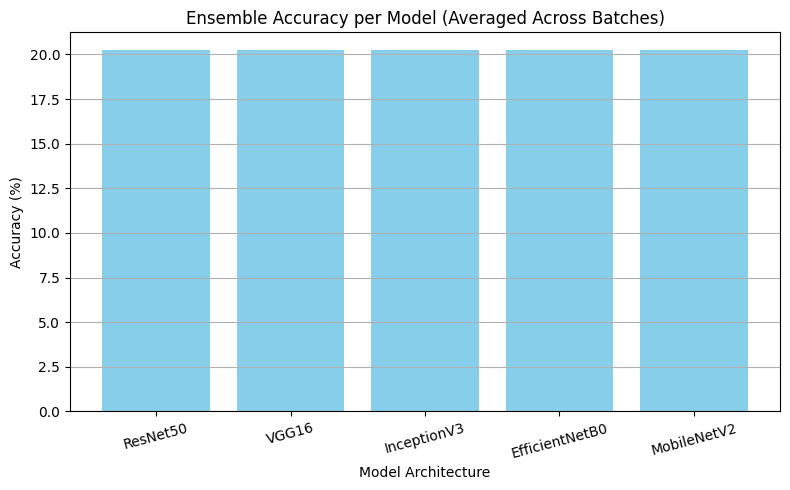

In [ ]:
import os
import numpy as np
import tensorflow as tf
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# ==========================================================
# Paths
# ==========================================================
base_dir = "/content/drive/MyDrive/solarPanelDefectDetection_Binary/binaryClassification/"
test_dir = os.path.join(base_dir, "test")
models_dir = "/content/drive/MyDrive/solarPanelDefectDetection_Binary/balancedClasses/model_results"
save_dir = "/content/drive/MyDrive/solarPanelDefectDetection_Binary/ensemble_results"
os.makedirs(save_dir, exist_ok=True)

img_size = (224, 224)
batch_size = 32

# ==========================================================
# 1️⃣ Load test data
# ==========================================================
test_datagen = ImageDataGenerator(rescale=1./255)
test_gen = test_datagen.flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)
class_labels = list(test_gen.class_indices.keys())
print("\nDetected classes:", class_labels)

# ==========================================================
# 2️⃣ Define model names
# ==========================================================
model_names = ["ResNet50", "VGG16", "InceptionV3", "EfficientNetB0", "MobileNetV2"]

# DataFrame to store results
results_df = pd.DataFrame(columns=["Model", "Accuracy", "Precision", "Recall", "F1-Score"])

# ==========================================================
# 🔒 Safe model loading function (handles focal_loss_fixed)
# ==========================================================
def load_model_safe(path):
    """
    Load model safely even if it was compiled with custom losses.
    """
    try:
        # Skip compilation since we only need inference
        return tf.keras.models.load_model(path, compile=False)
    except Exception as e:
        print(f"⚠️ Standard load failed: {e}")
        print("🔁 Retrying with custom focal loss definition...")

        # Define focal loss again for compatibility
        @tf.keras.utils.register_keras_serializable()
        def focal_loss_fixed(y_true, y_pred, gamma=2.0, alpha=0.25):
            y_pred = tf.clip_by_value(y_pred, 1e-7, 1.0 - 1e-7)
            ce = -y_true * tf.math.log(y_pred)
            weight = alpha * tf.pow(1.0 - y_pred, gamma)
            return tf.reduce_sum(weight * ce, axis=-1)

        return tf.keras.models.load_model(
            path,
            custom_objects={"focal_loss_fixed": focal_loss_fixed}
        )

# ==========================================================
# 3️⃣ Ensemble each model across batches
# ==========================================================
for model_name in model_names:
    print(f"\n==============================")
    print(f"🔹 Processing {model_name} Ensemble Across Batches")
    print(f"==============================")

    # Load all batch models for this architecture
    model_paths = [
        os.path.join(models_dir, f"SplitBalanced_batch_{i}_{model_name}.keras")
        for i in range(1, 5)
    ]

    models = []
    for path in model_paths:
        if os.path.exists(path):
            print(f"✅ Loading model: {path}")
            model = load_model_safe(path)
            models.append(model)
        else:
            print(f"⚠️ Model not found: {path}")

    # Skip if no models found
    if not models:
        print(f"🚫 No trained models found for {model_name}, skipping...")
        continue

    # Make predictions
    predictions = []
    for i, model in enumerate(models):
        print(f"\nPredicting with {model_name} from Batch {i+1}...")
        preds = model.predict(test_gen, verbose=1)
        predictions.append(preds)

    # Create ensemble (average predictions)
    print(f"\n🔮 Creating Ensemble for {model_name}...")
    avg_preds = np.mean(predictions, axis=0)
    y_pred = np.argmax(avg_preds, axis=1)
    y_true = test_gen.classes

    # ==========================================================
    # 5️⃣ Evaluate Ensemble Performance
    # ==========================================================
    ensemble_acc = accuracy_score(y_true, y_pred)
    print(f"\n✅ Ensemble {model_name} Test Accuracy: {ensemble_acc*100:.2f}%")

    # Detailed metrics
    report = classification_report(y_true, y_pred, target_names=class_labels, output_dict=True)
    precision = report["weighted avg"]["precision"]
    recall = report["weighted avg"]["recall"]
    f1 = report["weighted avg"]["f1-score"]

    # Add to results table
    results_df = pd.concat([
        results_df,
        pd.DataFrame({
            "Model": [model_name],
            "Accuracy": [ensemble_acc * 100],
            "Precision": [precision * 100],
            "Recall": [recall * 100],
            "F1-Score": [f1 * 100]
        })
    ], ignore_index=True)

    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_labels, yticklabels=class_labels)
    plt.title(f'Confusion Matrix - Ensemble {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.tight_layout()

    # Save confusion matrix as image
    cm_path = os.path.join(save_dir, f"{model_name}_confusion_matrix.png")
    plt.savefig(cm_path, dpi=300)
    plt.close()
    print(f"📊 Saved confusion matrix: {cm_path}")

# ==========================================================
# 6️⃣ Save results summary
# ==========================================================
csv_path = os.path.join(save_dir, "ensemble_results_summary.csv")
results_df.to_csv(csv_path, index=False)
print(f"\n✅ All ensemble results saved to: {csv_path}")

# ==========================================================
# 7️⃣ Summary of ensemble accuracies
# ==========================================================
print("\n==============================")
print("📊 Ensemble Model Accuracy Summary")
print("==============================")
print(results_df)

# Optional — visualize comparison
if not results_df.empty:
    plt.figure(figsize=(8, 5))
    plt.bar(results_df["Model"], results_df["Accuracy"], color="skyblue")
    plt.title("Ensemble Accuracy per Model (Averaged Across Batches)")
    plt.ylabel("Accuracy (%)")
    plt.xlabel("Model Architecture")
    plt.xticks(rotation=15)
    plt.grid(axis='y')
    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, "ensemble_accuracy_comparison.png"), dpi=300)
    plt.show()
else:
    print("⚠️ No results to visualize.")


In [ ]:
import os, glob
models_dir = "/content/drive/MyDrive/Project/solarPanelDefectDetection_Binary/balancedClasses/model_results"

print("Exists?", os.path.exists(models_dir))
print("Some files:")
for p in sorted(glob.glob(models_dir + "/**/*", recursive=True))[:50]:
    print(p)


Exists? False
Some files:


Training Accuracy: 0.9791666865348816
Validation Accuracy: 0.7352941036224365


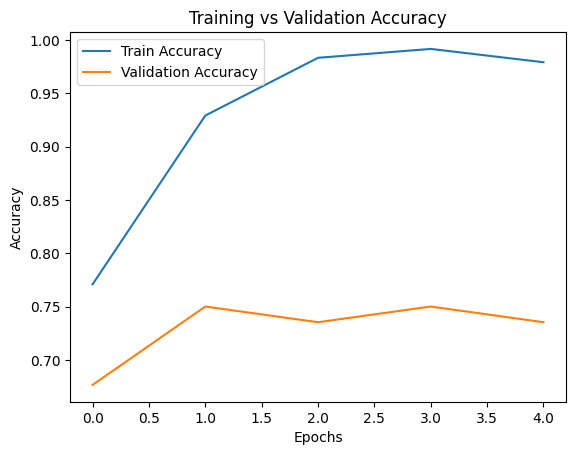

In [ ]:
# Print last epoch accuracy and validation accuracy
print("Training Accuracy:", history.history['accuracy'][-1])
print("Validation Accuracy:", history.history['val_accuracy'][-1])

# Or visualize the accuracy curve
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training vs Validation Accuracy')
plt.show()


In [ ]:
!ls "/content/drive/MyDrive/solarPanelDefectDetection_Binary/model_results"


SplitBalanced_batch_1_EfficientNetB0.keras
SplitBalanced_batch_1_InceptionV3.keras
SplitBalanced_batch_1_MobileNetV2.keras
SplitBalanced_batch_1_ResNet50.keras
SplitBalanced_batch_1_VGG16.keras
SplitBalanced_batch_2_EfficientNetB0.keras
SplitBalanced_batch_2_InceptionV3.keras
SplitBalanced_batch_2_MobileNetV2.keras
SplitBalanced_batch_2_ResNet50.keras
SplitBalanced_batch_2_VGG16.keras
SplitBalanced_batch_3_EfficientNetB0.keras
SplitBalanced_batch_3_InceptionV3.keras
SplitBalanced_batch_3_MobileNetV2.keras
SplitBalanced_batch_3_ResNet50.keras
SplitBalanced_batch_3_VGG16.keras
SplitBalanced_batch_4_EfficientNetB0.keras
SplitBalanced_batch_4_InceptionV3.keras
SplitBalanced_batch_4_MobileNetV2.keras
SplitBalanced_batch_4_ResNet50.keras
SplitBalanced_batch_4_VGG16.keras
training_log.csv


In [ ]:
import os
import pandas as pd

# Paths
results_dir = "/content/drive/MyDrive/solarPanelDefectDetection_Binary/model_results"
log_path = os.path.join(results_dir, "training_log.csv")

# Load your log
df = pd.read_csv(log_path)
logged_models = set(df["Model"].astype(str) + "_" + df["Batch"].astype(str))

# Find all .keras files
all_models = []
for f in os.listdir(results_dir):
    if f.endswith(".keras"):
        parts = f.replace(".keras", "").split("_")
        batch = "_".join(parts[0:2])  # e.g. SplitBalanced_batch_1
        model = parts[2]              # e.g. ResNet50
        all_models.append((batch, model))

# Find missing
missing = [(b, m) for (b, m) in all_models if f"{m}_{b}" not in logged_models]
print("🔍 Missing entries in training_log.csv:")
for b, m in missing:
    print(f"- {b} → {m}")


🔍 Missing entries in training_log.csv:
- SplitBalanced_batch → 1
- SplitBalanced_batch → 1
- SplitBalanced_batch → 1
- SplitBalanced_batch → 1
- SplitBalanced_batch → 1
- SplitBalanced_batch → 2
- SplitBalanced_batch → 2
- SplitBalanced_batch → 2
- SplitBalanced_batch → 2
- SplitBalanced_batch → 2
- SplitBalanced_batch → 3
- SplitBalanced_batch → 3
- SplitBalanced_batch → 3
- SplitBalanced_batch → 3
- SplitBalanced_batch → 3
- SplitBalanced_batch → 4
- SplitBalanced_batch → 4
- SplitBalanced_batch → 4
- SplitBalanced_batch → 4
- SplitBalanced_batch → 4


In [ ]:
import os
import pandas as pd
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np

# Paths
results_dir = "/content/drive/MyDrive/solarPanelDefectDetection_Binary/model_results"
base_dir = "/content/drive/MyDrive/solarPanelDefectDetection_Binary/balancedClasses"
log_path = os.path.join(results_dir, "training_log.csv")

IMG_SIZE = (224, 224)
BATCH_SIZE = 32

# Load existing log (if available)
if os.path.exists(log_path):
    df = pd.read_csv(log_path)
else:
    df = pd.DataFrame(columns=["Batch", "Model", "Test Accuracy", "Best Val Accuracy", "Best Val Loss"])

# Existing entries
logged_pairs = set(zip(df["Batch"], df["Model"]))

# Prepare test data generator
test_datagen = ImageDataGenerator(rescale=1./255)

new_rows = []

# Iterate over all model files
for file in os.listdir(results_dir):
    if not file.endswith(".keras"):
        continue

    # Example file: SplitBalanced_batch_3_ResNet50.keras
    parts = file.replace(".keras", "").split("_")
    batch = "_".join(parts[0:3]) if len(parts) >= 3 else parts[0]
    model_name = parts[-1]

    if (batch, model_name) in logged_pairs:
        print(f"⏭ Skipping {model_name} on {batch} — already logged")
        continue

    model_path = os.path.join(results_dir, file)
    test_dir = os.path.join(base_dir, batch, "test")

    if not os.path.exists(test_dir):
        print(f"Test folder not found for {batch}, skipping...")
        continue

    print(f"Evaluating {model_name} on {batch} ...")

    try:
        model = load_model(model_path)

        test_gen = test_datagen.flow_from_directory(
            test_dir,
            target_size=IMG_SIZE,
            batch_size=BATCH_SIZE,
            class_mode='binary',
            shuffle=False
        )

        loss, acc = model.evaluate(test_gen, verbose=0)
        print(f"{model_name} on {batch} — Test Accuracy: {acc:.4f}")

        new_rows.append({
            "Batch": batch,
            "Model": model_name,
            "Test Accuracy": acc,
            "Best Val Accuracy": np.nan,
            "Best Val Loss": np.nan
        })

    except Exception as e:
        print(f"Error evaluating {model_name} on {batch}: {e}")

# Append new results to CSV
if new_rows:
    df = pd.concat([df, pd.DataFrame(new_rows)], ignore_index=True)
    df.to_csv(log_path, index=False)
    print(f"\nUpdated training_log.csv with {len(new_rows)} new entries.")
else:
    print("\nAll models already logged.")


Evaluating ResNet50 on SplitBalanced_batch_1 ...
Found 36 images belonging to 2 classes.


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


ResNet50 on SplitBalanced_batch_1 — Test Accuracy: 0.5000
Evaluating VGG16 on SplitBalanced_batch_1 ...
Found 36 images belonging to 2 classes.
VGG16 on SplitBalanced_batch_1 — Test Accuracy: 0.5000
Evaluating InceptionV3 on SplitBalanced_batch_1 ...
Found 36 images belonging to 2 classes.
InceptionV3 on SplitBalanced_batch_1 — Test Accuracy: 0.6111
Evaluating EfficientNetB0 on SplitBalanced_batch_1 ...
Found 36 images belonging to 2 classes.


EfficientNetB0 on SplitBalanced_batch_1 — Test Accuracy: 0.5000
Evaluating MobileNetV2 on SplitBalanced_batch_1 ...
Found 36 images belonging to 2 classes.


MobileNetV2 on SplitBalanced_batch_1 — Test Accuracy: 0.7500
Evaluating ResNet50 on SplitBalanced_batch_2 ...
Found 36 images belonging to 2 classes.
ResNet50 on SplitBalanced_batch_2 — Test Accuracy: 0.5000
Evaluating VGG16 on SplitBalanced_batch_2 ...
Found 36 images belonging to 2 classes.
VGG16 on SplitBalanced_batch_2 — Test Accuracy: 0.4722
Evaluating InceptionV3 on SplitBalanced_batch_2 ...
Found 36 images belonging to 2 classes.
InceptionV3 on SplitBalanced_batch_2 — Test Accuracy: 0.7778
Evaluating EfficientNetB0 on SplitBalanced_batch_2 ...
Found 36 images belonging to 2 classes.
EfficientNetB0 on SplitBalanced_batch_2 — Test Accuracy: 0.5000
Evaluating MobileNetV2 on SplitBalanced_batch_2 ...
Found 36 images belonging to 2 classes.
MobileNetV2 on SplitBalanced_batch_2 — Test Accuracy: 0.8056
Evaluating ResNet50 on SplitBalanced_batch_3 ...
Found 36 images belonging to 2 classes.
ResNet50 on SplitBalanced_batch_3 — Test Accuracy: 0.5000
Evaluating VGG16 on SplitBalanced_batch

In [ ]:
import pandas as pd

df = pd.read_csv("/content/drive/MyDrive/solarPanelDefectDetection_Binary/balancedClasses/model_results/training_log.csv")
print(df.head(20))


                    Batch           Model  Best Val Accuracy  Best Val Loss  \
0   SplitBalanced_batch_1           VGG16             0.7353         0.0342   
1   SplitBalanced_batch_1     InceptionV3             0.8971         0.0256   
2   SplitBalanced_batch_1  EfficientNetB0             0.5000         0.0434   
3   SplitBalanced_batch_1     MobileNetV2             0.8235         0.0311   
4   SplitBalanced_batch_2        ResNet50             0.7206         0.0395   
5   SplitBalanced_batch_2           VGG16             0.5441         0.0429   
6   SplitBalanced_batch_2     InceptionV3             0.8971         0.0185   
7   SplitBalanced_batch_2  EfficientNetB0             0.5000         0.0434   
8   SplitBalanced_batch_2     MobileNetV2             0.8382         0.0316   
9   SplitBalanced_batch_3        ResNet50             0.5000         0.0457   
10  SplitBalanced_batch_3           VGG16             0.8971         0.0225   
11  SplitBalanced_batch_3     InceptionV3           

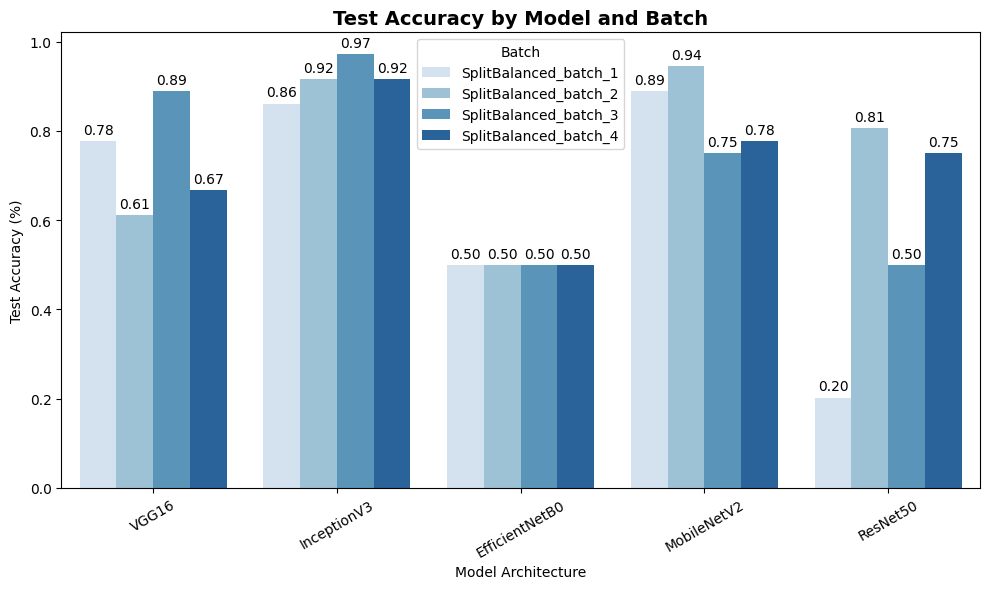

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Load your CSV
df = pd.read_csv("/content/drive/MyDrive/solarPanelDefectDetection_Binary/balancedClasses/model_results/training_log.csv")

# Plot the bar chart
plt.figure(figsize=(10,6))
ax = sns.barplot(data=df, x="Model", y="Test Accuracy", hue="Batch", palette="Blues")

# Add title and labels
plt.title("Test Accuracy by Model and Batch", fontsize=14, weight='bold')
plt.xlabel("Model Architecture")
plt.ylabel("Test Accuracy (%)")
plt.xticks(rotation=30)

# ===============================
# 🧠 Add accuracy labels on bars
# ===============================
for container in ax.containers:
    ax.bar_label(container, fmt="%.2f", label_type="edge", fontsize=10, padding=3)

# Display the plot
plt.tight_layout()
plt.show()


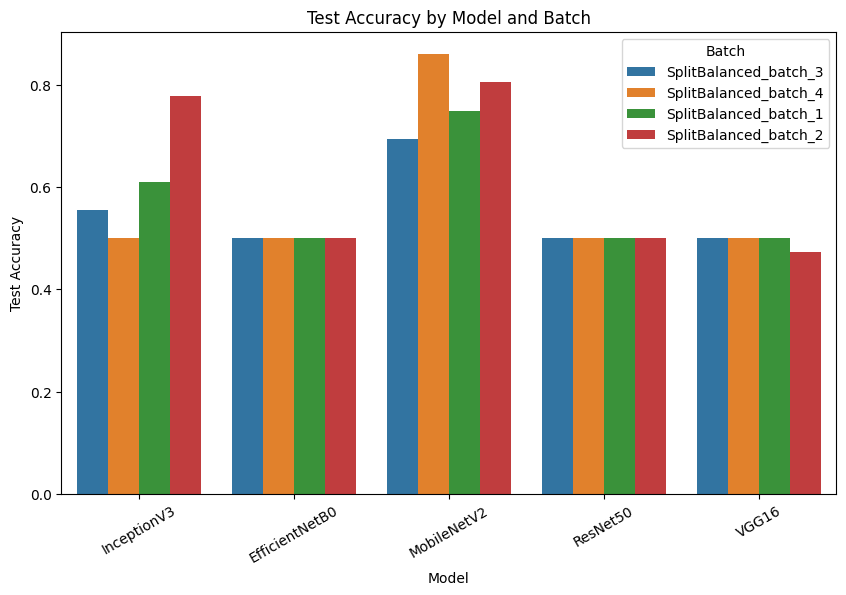

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv("/content/drive/MyDrive/solarPanelDefectDetection_Binary/balancedClasses/training_log.csv")
plt.figure(figsize=(10,6))
sns.barplot(data=df, x="Model", y="Test Accuracy", hue="Batch")
plt.title("Test Accuracy by Model and Batch")
plt.xticks(rotation=30)
plt.show()


In [ ]:
import pandas as pd

LOG_FILE = "/content/drive/MyDrive/solarPanelDefectDetection_Binary/balancedClasses/model_results/training_log.csv"
df = pd.read_csv(LOG_FILE)
print(df)


                    Batch           Model  Best Val Accuracy  Best Val Loss  \
0   SplitBalanced_batch_1           VGG16             0.7353         0.0342   
1   SplitBalanced_batch_1     InceptionV3             0.8971         0.0256   
2   SplitBalanced_batch_1  EfficientNetB0             0.5000         0.0434   
3   SplitBalanced_batch_1     MobileNetV2             0.8235         0.0311   
4   SplitBalanced_batch_2        ResNet50             0.7206         0.0395   
5   SplitBalanced_batch_2           VGG16             0.5441         0.0429   
6   SplitBalanced_batch_2     InceptionV3             0.8971         0.0185   
7   SplitBalanced_batch_2  EfficientNetB0             0.5000         0.0434   
8   SplitBalanced_batch_2     MobileNetV2             0.8382         0.0316   
9   SplitBalanced_batch_3        ResNet50             0.5000         0.0457   
10  SplitBalanced_batch_3           VGG16             0.8971         0.0225   
11  SplitBalanced_batch_3     InceptionV3           

In [ ]:
import itertools as it

expected = set(it.product(
    ["ResNet50","VGG16","InceptionV3","MobileNetV2","EfficientNetB0"],
    [f"SplitBalanced_batch_{i}" for i in [1,2,3,4]]
))
present = set(zip(df["Model"].astype(str), df["Batch"].astype(str)))
missing = sorted(expected - present)

print("Missing (Model, Batch) combos:")
for m in missing:
    print(m)


Missing (Model, Batch) combos:
('ResNet50', 'SplitBalanced_batch_1')


In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import accuracy_score

# ---- paths (adjust if needed) ----
csv_path = "/content/drive/MyDrive/solarPanelDefectDetection_Binary/balancedClasses/model_results/training_log.csv"
models_dir = "/content/drive/MyDrive/solarPanelDefectDetection_Binary/balancedClasses/model_results"
test_dir = "/content/drive/MyDrive/solarPanelDefectDetection_Binary/binaryClassification/test"
model_path = os.path.join(models_dir, "SplitBalanced_batch_1_ResNet50.keras")

# ---- load test data ----
img_size = (224,224)
batch_size = 32
test_gen = ImageDataGenerator(rescale=1./255).flow_from_directory(
    test_dir, target_size=img_size, batch_size=batch_size,
    class_mode='categorical', shuffle=False
)

# ---- safe load model (compile=False handles custom loss) ----
model = tf.keras.models.load_model(model_path, compile=False)

# ---- evaluate to get test accuracy ----
y_true = test_gen.classes
y_prob = model.predict(test_gen, verbose=1)
y_pred = np.argmax(y_prob, axis=1)
test_acc = accuracy_score(y_true, y_pred)  # 0..1

# ---- append row to CSV ----
df = pd.read_csv(csv_path)
new_row = {
    "Batch": "SplitBalanced_batch_1",
    "Model": "ResNet50",
    "Best Val Accuracy": np.nan,  # fill if you have it
    "Best Val Loss": np.nan,      # fill if you have it
    "Test Accuracy": test_acc
}
df = pd.concat([df, pd.DataFrame([new_row])], ignore_index=True)
df.to_csv(csv_path, index=False)

print(f"Added ResNet50 / SplitBalanced_batch_1 with Test Accuracy = {test_acc*100:.2f}%")


Found 89 images belonging to 2 classes.


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


3/3 ━━━━━━━━━━━━━━━━━━━━ 21s 6s/step
Added ResNet50 / SplitBalanced_batch_1 with Test Accuracy = 20.22%


Best model loaded successfully!
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
Prediction: Defective (Confidence: 0.0000)


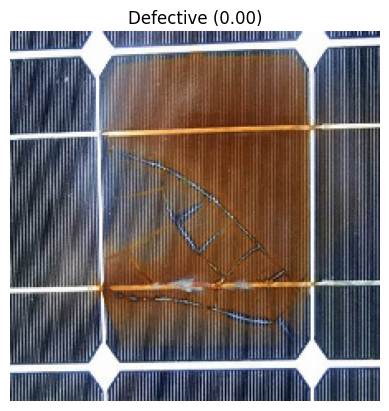

In [ ]:
BEST_MODEL_PATH = "/content/drive/MyDrive/solarPanelDefectDetection_Binary/model_results/SplitBalanced_batch_4_MobileNetV2.keras"
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import numpy as np

model = load_model(BEST_MODEL_PATH)
print("Best model loaded successfully!")

IMG_SIZE = (224, 224)

# Try a test image
img_path = "/content/drive/MyDrive/solarPanelDefectDetection_Binary/binaryClassification/test/defective/Electrical (30).jpg"

img = image.load_img(img_path, target_size=IMG_SIZE)
img_array = image.img_to_array(img) / 255.0
img_array = np.expand_dims(img_array, axis=0)

prediction = model.predict(img_array)[0][0]
label = "Non-Defective" if prediction >= 0.5 else "Defective"
print(f"Prediction: {label} (Confidence: {prediction:.4f})")
import matplotlib.pyplot as plt

plt.imshow(img_array[0])
plt.title(f"{label} ({prediction:.2f})")
plt.axis('off')
plt.show()


In [ ]:
import os
import gc
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import (
    ResNet50, VGG16, InceptionV3, EfficientNetB0, MobileNetV2
)
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
BASE_DIR = "/content/drive/MyDrive/solarPanelDefectDetection_Binary/balancedClasses"
SAVE_DIR = "/content/drive/MyDrive/solarPanelDefectDetection_Binary/balancedClasses/model_results"
LOG_FILE = os.path.join(SAVE_DIR, "training_log.csv")
os.makedirs(SAVE_DIR, exist_ok=True)
BATCHES = [f"SplitBalanced_batch_{i}" for i in range(1, 5)]
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 20
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=25,
    width_shift_range=0.15,
    height_shift_range=0.15,
    zoom_range=0.25,
    brightness_range=[0.7, 1.3],
    horizontal_flip=True,
    vertical_flip=True,
    shear_range=0.2,
    fill_mode='nearest'
)
val_test_datagen = ImageDataGenerator(rescale=1./255)
def focal_loss(gamma=2., alpha=0.25):
    def focal_loss_fixed(y_true, y_pred):
        bce = tf.keras.losses.binary_crossentropy(y_true, y_pred)
        bce_exp = tf.exp(-bce)
        return alpha * (1 - bce_exp) ** gamma * bce
    return focal_loss_fixed
def get_model_list(input_shape=(224, 224, 3)):
    models_list = []
    def build_model(base_model, name):
        for layer in base_model.layers[:-30]:
            layer.trainable = False
        for layer in base_model.layers[-30:]:
            layer.trainable = True
        x = layers.GlobalAveragePooling2D()(base_model.output)
        x = layers.BatchNormalization()(x)
        x = layers.Dense(256, activation='relu')(x)
        x = layers.Dropout(0.4)(x)
        x = layers.Dense(128, activation='relu')(x)
        x = layers.Dropout(0.3)(x)
        output = layers.Dense(1, activation='sigmoid')(x)
        model = models.Model(inputs=base_model.input, outputs=output, name=name)
        model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
                      loss=focal_loss(), metrics=['accuracy'])
        return model
    bases = [
        (ResNet50, "ResNet50"),
        (VGG16, "VGG16"),
        (InceptionV3, "InceptionV3"),
        (EfficientNetB0, "EfficientNetB0"),
        (MobileNetV2, "MobileNetV2"),
    ]
    for cls, name in bases:
        base = cls(weights='imagenet', include_top=False, input_shape=input_shape)
        models_list.append(build_model(base, name))
    return models_list
results = []
for batch_name in BATCHES:
    print(f"\n===== 🔹 Training on {batch_name} 🔹 =====")
    batch_path = os.path.join(BASE_DIR, batch_name)
    train_gen = train_datagen.flow_from_directory(
        os.path.join(batch_path, "train"),
        target_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='binary'
    )
    val_gen = val_test_datagen.flow_from_directory(
        os.path.join(batch_path, "val"),
        target_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='binary'
    )
    test_gen = val_test_datagen.flow_from_directory(
        os.path.join(batch_path, "test"),
        target_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='binary',
        shuffle=False
    )
    models_list = get_model_list()
    for model in models_list:
        save_path = f"{SAVE_DIR}/{batch_name}_{model.name}.keras"
        if os.path.exists(save_path):
            print(f"⏭ Skipping {model.name} — already trained for {batch_name}")
            continue
        print(f"\nTraining model: {model.name} on {batch_name}")
        callbacks = [
            EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1),
            ModelCheckpoint(save_path, monitor='val_accuracy', save_best_only=True, verbose=1)
        ]
        history = model.fit(
            train_gen,
            validation_data=val_gen,
            epochs=EPOCHS,
            callbacks=callbacks,
            verbose=1,
            class_weight={0: 1.0, 1: 1.8}
        )
        # Evaluate on test data
        test_loss, test_acc = model.evaluate(test_gen, verbose=0)
        best_val_acc = max(history.history['val_accuracy'])
        best_val_loss = min(history.history['val_loss'])
        print(f"{model.name} on {batch_name}: Test Accuracy={test_acc:.4f}, Best Val Acc={best_val_acc:.4f}")
        results.append({
            "Batch": batch_name,
            "Model": model.name,
            "Best Val Accuracy": round(best_val_acc, 4),
            "Best Val Loss": round(best_val_loss, 4),
            "Test Accuracy": round(test_acc, 4)
        })
        pd.DataFrame(results).to_csv(LOG_FILE, index=False)
        print(f"Logged results to {LOG_FILE}")
        del model
        K.clear_session()
        gc.collect()

print("\Training completed successfully!")


===== 🔹 Training on SplitBalanced_batch_1 🔹 =====
Found 240 images belonging to 2 classes.
Found 68 images belonging to 2 classes.
Found 36 images belonging to 2 classes.


<>:128: SyntaxWarning: invalid escape sequence '\T'
<>:128: SyntaxWarning: invalid escape sequence '\T'
/tmp/ipython-input-2573680330.py:128: SyntaxWarning: invalid escape sequence '\T'
  print("\Training completed successfully!")


⏭ Skipping ResNet50 — already trained for SplitBalanced_batch_1

Training model: VGG16 on SplitBalanced_batch_1


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.5729 - loss: 0.0787
Epoch 1: val_accuracy improved from -inf to 0.50000, saving model to /content/drive/MyDrive/solarPanelDefectDetection_Binary/balancedClasses/model_results/SplitBalanced_batch_1_VGG16.keras
8/8 ━━━━━━━━━━━━━━━━━━━━ 92s 9s/step - accuracy: 0.5727 - loss: 0.0775 - val_accuracy: 0.5000 - val_loss: 0.0449
Epoch 2/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5714 - loss: 0.0540
Epoch 2: val_accuracy improved from 0.50000 to 0.64706, saving model to /content/drive/MyDrive/solarPanelDefectDetection_Binary/balancedClasses/model_results/SplitBalanced_batch_1_VGG16.keras
8/8 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.5787 - loss: 0.0538 - val_accuracy: 0.6471 - val_loss: 0.0411
Epoch 3/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 917ms/step - accuracy: 0.6159 - loss: 0.0540
Epoch 3: val_accuracy did not improve from 0.64706
8/8 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.6174 - loss: 0.0538 - val_accuracy: 0.5000 - v

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


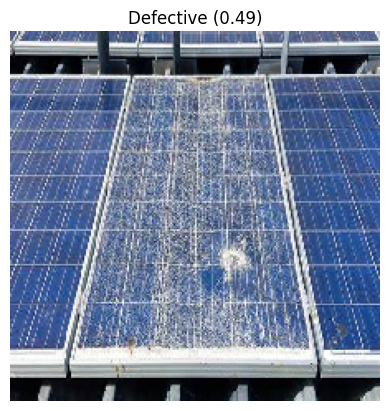

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt

# --- define focal loss again ---
def focal_loss(gamma=2., alpha=0.25):
    def focal_loss_fixed(y_true, y_pred):
        bce = tf.keras.losses.binary_crossentropy(y_true, y_pred)
        bce_exp = tf.exp(-bce)
        return alpha * (1 - bce_exp) ** gamma * bce
    return focal_loss_fixed

BEST_MODEL_PATH = "/content/drive/MyDrive/solarPanelDefectDetection_Binary/balancedClasses/model_results/SplitBalanced_batch_4_ResNet50.keras"
model = load_model(BEST_MODEL_PATH, custom_objects={'focal_loss_fixed': focal_loss()})
IMG_SIZE = (224, 224)

img_path = "/content/drive/MyDrive/solarPanelDefectDetection_Binary/binaryClassification/test/defective/Physical (42).jpg"
img = image.load_img(img_path, target_size=IMG_SIZE)
img_array = image.img_to_array(img) / 255.0
img_array = np.expand_dims(img_array, axis=0)

prediction = model.predict(img_array)[0][0]
label = "Non-Defective" if prediction >= 0.5 else "Defective"

plt.imshow(img_array[0])
plt.title(f"{label} ({prediction:.2f})")
plt.axis('off')
plt.show()


In [ ]:
!ls /content/drive/MyDrive/solarPanelDefectDetection_Binary/balancedClasses/SplitBalanced_batch_4/

test  train  val


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


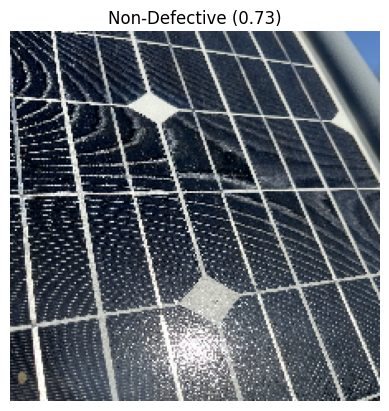

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt

# --- define focal loss again ---
def focal_loss(gamma=2., alpha=0.25):
    def focal_loss_fixed(y_true, y_pred):
        bce = tf.keras.losses.binary_crossentropy(y_true, y_pred)
        bce_exp = tf.exp(-bce)
        return alpha * (1 - bce_exp) ** gamma * bce
    return focal_loss_fixed

BEST_MODEL_PATH = "/content/drive/MyDrive/solarPanelDefectDetection_Binary/balancedClasses/model_results/SplitBalanced_batch_4_MobileNetV2.keras"
model = load_model(BEST_MODEL_PATH, custom_objects={'focal_loss_fixed': focal_loss()})
IMG_SIZE = (224, 224)

img_path = "/content/drive/MyDrive/solarPanelDefectDetection_Binary/balancedClasses/SplitBalanced_batch_1/test/non_defective/Clean (42).jpg"
img = image.load_img(img_path, target_size=IMG_SIZE)
img_array = image.img_to_array(img) / 255.0
img_array = np.expand_dims(img_array, axis=0)

prediction = model.predict(img_array)[0][0]
label = "Non-Defective" if prediction >= 0.5 else "Defective"

plt.imshow(img_array[0])
plt.title(f"{label} ({prediction:.2f})")
plt.axis('off')
plt.show()


In [ ]:
import pandas as pd

LOG_FILE = "/content/drive/MyDrive/solarPanelDefectDetection_Binary/balancedClasses/model_results/training_log.csv"

# Load the log file
df = pd.read_csv(LOG_FILE)
print("🔹 All Results:")
display(df)

# Sort by Test Accuracy (or Val Accuracy if you prefer)
best = df.sort_values(by="Test Accuracy", ascending=False).head(10)
print("\nTop Performing Models:")
display(best)

# Get the single best one
best_model_row = best.iloc[0]
print("\nBest Overall:")
print(best_model_row)


🔹 All Results:


,Batch,Model,Best Val Accuracy,Best Val Loss,Test Accuracy
0,SplitBalanced_batch_1,VGG16,0.7353,0.0342,0.7778
1,SplitBalanced_batch_1,InceptionV3,0.8971,0.0256,0.8611
2,SplitBalanced_batch_1,EfficientNetB0,0.5000,0.0434,0.5000
3,SplitBalanced_batch_1,MobileNetV2,0.8235,0.0311,0.8889
4,SplitBalanced_batch_2,ResNet50,0.7206,0.0395,0.8056
5,SplitBalanced_batch_2,VGG16,0.5441,0.0429,0.6111
6,SplitBalanced_batch_2,InceptionV3,0.8971,0.0185,0.9167
7,SplitBalanced_batch_2,EfficientNetB0,0.5000,0.0434,0.5000
8,SplitBalanced_batch_2,MobileNetV2,0.8382,0.0316,0.9444
9,SplitBalanced_batch_3,ResNet50,0.5000,0.0457,0.5000



Top Performing Models:


,Batch,Model,Best Val Accuracy,Best Val Loss,Test Accuracy
11,SplitBalanced_batch_3,InceptionV3,0.9118,0.0154,0.9722
8,SplitBalanced_batch_2,MobileNetV2,0.8382,0.0316,0.9444
16,SplitBalanced_batch_4,InceptionV3,0.9118,0.0199,0.9167
6,SplitBalanced_batch_2,InceptionV3,0.8971,0.0185,0.9167
10,SplitBalanced_batch_3,VGG16,0.8971,0.0225,0.8889
3,SplitBalanced_batch_1,MobileNetV2,0.8235,0.0311,0.8889
1,SplitBalanced_batch_1,InceptionV3,0.8971,0.0256,0.8611
4,SplitBalanced_batch_2,ResNet50,0.7206,0.0395,0.8056
0,SplitBalanced_batch_1,VGG16,0.7353,0.0342,0.7778
18,SplitBalanced_batch_4,MobileNetV2,0.7059,0.0441,0.7778



Best Overall:
Batch                SplitBalanced_batch_3
Model                          InceptionV3
Best Val Accuracy                   0.9118
Best Val Loss                       0.0154
Test Accuracy                       0.9722
Name: 11, dtype: object


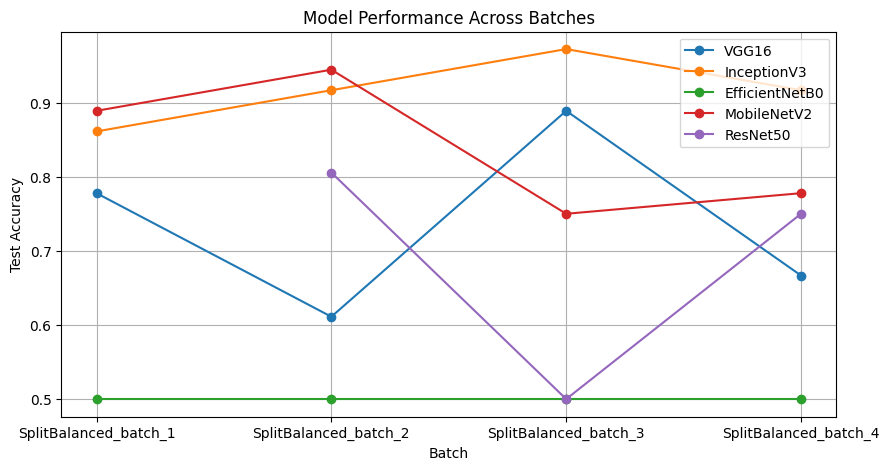

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
for model in df['Model'].unique():
    subset = df[df['Model'] == model]
    plt.plot(subset['Batch'], subset['Test Accuracy'], marker='o', label=model)

plt.title("Model Performance Across Batches")
plt.xlabel("Batch")
plt.ylabel("Test Accuracy")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Average
from tensorflow.keras import Model, Input
import tensorflow as tf
import os # Import the os module

# --- Re-declare focal loss (needed to load models) ---
def focal_loss(gamma=2., alpha=0.25):
    def focal_loss_fixed(y_true, y_pred):
        bce = tf.keras.losses.binary_crossentropy(y_true, y_pred)
        bce_exp = tf.exp(-bce)
        return alpha * (1 - bce_exp) ** gamma * bce
    return focal_loss_fixed

# --- Path to your saved models ---
MODEL_DIR = "/content/drive/MyDrive/solarPanelDefectDetection_Binary/balancedClasses/model_results"
batch_name = "SplitBalanced_batch_3"  # (or whichever batch gave best results)

model_paths = [
    f"{MODEL_DIR}/{batch_name}_ResNet50.keras",
    f"{MODEL_DIR}/{batch_name}_VGG16.keras",
    f"{MODEL_DIR}/{batch_name}_InceptionV3.keras",
    f"{MODEL_DIR}/{batch_name}_EfficientNetB0.keras",
    f"{MODEL_DIR}/{batch_name}_MobileNetV2.keras",
]

loaded_models = []
for path in model_paths:
    if os.path.exists(path):
        print(f"Loading {os.path.basename(path)}")
        try:
            # Pass the custom object when loading individual models
            m = load_model(path, custom_objects={'focal_loss_fixed': focal_loss()})
            m.trainable = False
            loaded_models.append(m)
        except Exception as e:
            print(f"Error loading model {os.path.basename(path)}: {e}")
    else:
        print(f"Model not found: {path}")

# --- Create Ensemble ---
if len(loaded_models) > 1:
    input_tensor = Input(shape=(224, 224, 3))
    outputs = [m(input_tensor) for m in loaded_models]
    avg_output = Average()(outputs)
    ensemble_model = Model(inputs=input_tensor, outputs=avg_output, name="EnsembleModel")

    # Compile
    ensemble_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    # Save the ensemble model
    ensemble_path = f"{MODEL_DIR}/{batch_name}_Ensemble.keras"
    ensemble_model.save(ensemble_path)
    print(f"\nEnsemble model saved at: {ensemble_path}")
else:
    print("No models found to ensemble.")

Loading SplitBalanced_batch_3_ResNet50.keras
Loading SplitBalanced_batch_3_VGG16.keras
Loading SplitBalanced_batch_3_InceptionV3.keras
Loading SplitBalanced_batch_3_EfficientNetB0.keras
Loading SplitBalanced_batch_3_MobileNetV2.keras

Ensemble model saved at: /content/drive/MyDrive/solarPanelDefectDetection_Binary/balancedClasses/model_results/SplitBalanced_batch_3_Ensemble.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step


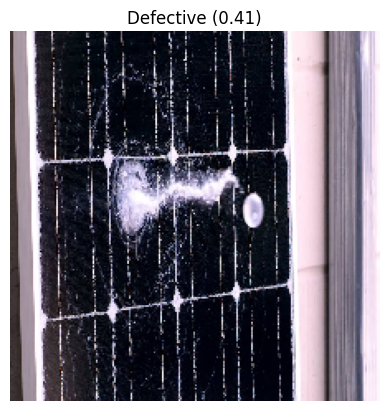

In [ ]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

# Define and register the custom focal loss function
@tf.keras.utils.register_keras_serializable()
def focal_loss_fixed(y_true, y_pred, gamma=2., alpha=0.25):
    bce = tf.keras.losses.binary_crossentropy(y_true, y_pred)
    bce_exp = tf.exp(-bce)
    return alpha * (1 - bce_exp) ** gamma * bce


ensemble_model = load_model(
    "/content/drive/MyDrive/solarPanelDefectDetection_Binary/balancedClasses/model_results/SplitBalanced_batch_3_Ensemble.keras",
    custom_objects={'focal_loss_fixed': focal_loss_fixed}
)

IMG_SIZE = (224, 224)
img_path = "/content/drive/MyDrive/solarPanelDefectDetection_Binary/binaryClassification/test/defective/Physical (33).jpg"

img = image.load_img(img_path, target_size=IMG_SIZE)
img_array = image.img_to_array(img) / 255.0
img_array = np.expand_dims(img_array, axis=0)

prediction = ensemble_model.predict(img_array)[0][0]
label = "Non-Defective" if prediction >= 0.5 else "Defective"

plt.imshow(img_array[0])
plt.title(f"{label} ({prediction:.2f})")
plt.axis('off')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


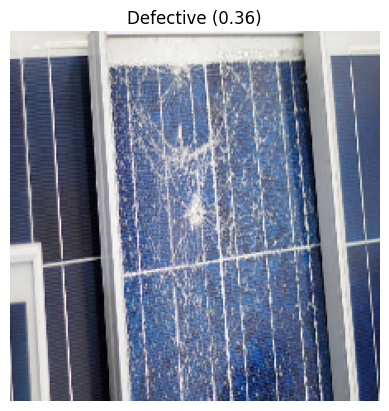

In [ ]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

# Define and register the custom focal loss function
@tf.keras.utils.register_keras_serializable()
def focal_loss_fixed(y_true, y_pred, gamma=2., alpha=0.25):
    bce = tf.keras.losses.binary_crossentropy(y_true, y_pred)
    bce_exp = tf.exp(-bce)
    return alpha * (1 - bce_exp) ** gamma * bce


ensemble_model = load_model(
    "/content/drive/MyDrive/solarPanelDefectDetection_Binary/balancedClasses/model_results/SplitBalanced_batch_3_Ensemble.keras",
    custom_objects={'focal_loss_fixed': focal_loss_fixed}
)

IMG_SIZE = (224, 224)
img_path = "/content/drive/MyDrive/solarPanelDefectDetection_Binary/binaryClassification/test/defective/Physical (64).jpg"

img = image.load_img(img_path, target_size=IMG_SIZE)
img_array = image.img_to_array(img) / 255.0
img_array = np.expand_dims(img_array, axis=0)

prediction = ensemble_model.predict(img_array)[0][0]
label = "Non-Defective" if prediction >= 0.5 else "Defective"

plt.imshow(img_array[0])
plt.title(f"{label} ({prediction:.2f})")
plt.axis('off')
plt.show()